In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARIMA
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
import chart_studio.plotly as ply
import cufflinks as cf
from arch import arch_model
from tbats import BATS, TBATS
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
plt.rcParams.update(params)
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_us = pd.read_csv('us.csv')

In [3]:
df_us.set_index('date', inplace = True)

In [4]:
df_us.shape

(244, 2)

In [5]:
df_us.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


<AxesSubplot:title={'center':'Number of Cases in United States'}, xlabel='Date'>

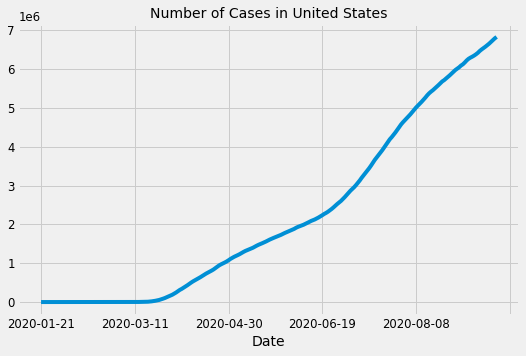

In [6]:
df_us['cases'].plot(xlabel = 'Date', title = 'Number of Cases in United States')

In [7]:
df_us['case_day'] = df_us['cases'].diff()
df_us['case_day'][0] = 1
df_us['case_day'] =  df_us['case_day'].astype('int')

In [8]:
df_us['case_day']

date
2020-01-21        1
2020-01-22        0
2020-01-23        0
2020-01-24        1
2020-01-25        1
              ...  
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, Length: 244, dtype: int32

In [9]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

<AxesSubplot:title={'center':'Number of New Cases'}, xlabel='Date', ylabel='New Cases per Day'>

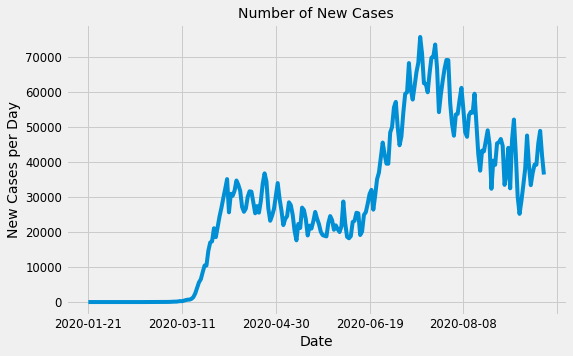

In [10]:
df_us['case_day'].plot(ylabel = 'New Cases per Day', xlabel = 'Date', title = 'Number of New Cases')

<AxesSubplot:xlabel='date'>

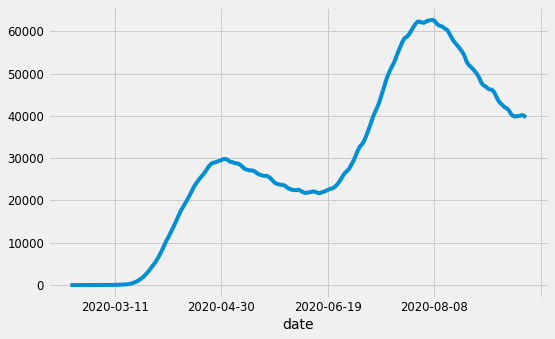

In [11]:
df_us['case_day'].rolling(30).mean().plot()

In [12]:
df_us[df_us['case_day'] == df_us['case_day'].max()]

,cases,deaths,case_day
date,,,
2020-07-16,3589349,138284,75682


In [13]:
test = adfuller(df_us['case_day'])
test_cases_day = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_cases_day)
# P-value > 0.05 Not Stationary


Test Statstic                   -1.803998
p-value                          0.378478
#Lags Used                       0.000000
Number of Observations Used    243.000000
dtype: float64


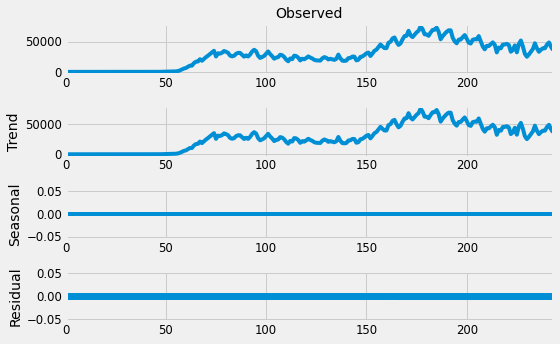

In [14]:
sd = seasonal_decompose(np.array(df_us['case_day']), model='additive', freq=1)
sd.plot()
plt.show()

## Differencing 


In [15]:
diff1 = df_us['case_day'] - df_us['case_day'].shift(1)

In [16]:
diff1 = diff1.dropna()

In [17]:
test = adfuller(diff1)
test_diff1 = pd.Series(test[0:4], index = ['Test Statstic', 'p-value', '#Lags Used', 'Number of Observations Used'])
print(test_diff1)
# pvalue still < 0.05 
# Series Stationary

Test Statstic                 -1.408123e+01
p-value                        2.826384e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.420000e+02
dtype: float64


<AxesSubplot:title={'center':'Differenced Series'}, xlabel='Date', ylabel='New Cases per Day'>

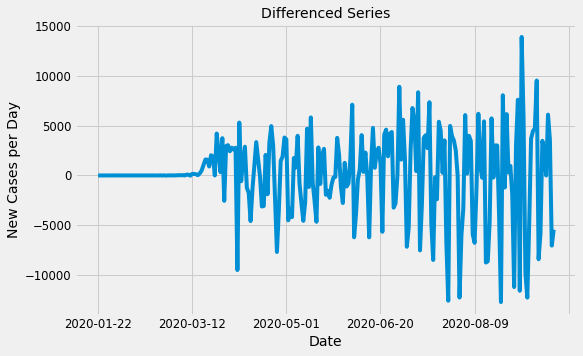

In [18]:
diff1.plot(ylabel = 'New Cases per Day', xlabel = 'Date', title = 'Differenced Series')

## Plotting ACF and PACF

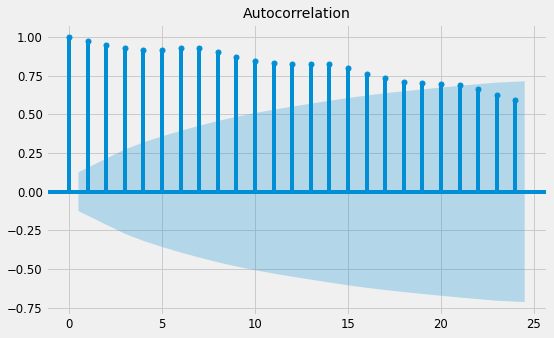

In [19]:
plot_acf(df_us['case_day'], alpha = 0.05) # q = 1-20
plt.show()

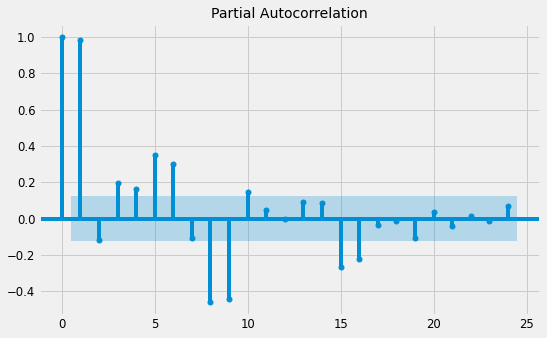

In [20]:
plot_pacf(df_us['case_day'], alpha = 0.05) # p = 3
plt.show()

## Train Test Split
This function is used to reduce the number of xticks

In [21]:
def helper_plot(n):
    every_nth = n
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)   

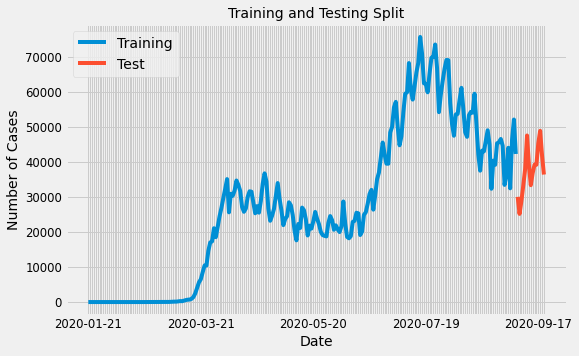

In [22]:
train = df_us['case_day'].loc['2020-01-21':'2020-09-05']
test = df_us['case_day'].loc['2020-09-06':]
fig, ax = plt.subplots()
plt.plot(train, label = 'Training')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Training and Testing Split')
helper_plot(60)
plt.show()

## BASELINE NAIVE

In [23]:
naive_preds = test.copy()
naive_preds.values[:] = train[len(train)-1]

In [24]:
naive_preds

date
2020-09-06    42278
2020-09-07    42278
2020-09-08    42278
2020-09-09    42278
2020-09-10    42278
2020-09-11    42278
2020-09-12    42278
2020-09-13    42278
2020-09-14    42278
2020-09-15    42278
2020-09-16    42278
2020-09-17    42278
2020-09-18    42278
2020-09-19    42278
2020-09-20    42278
Name: case_day, dtype: int32

In [25]:
naive_RMSE = np.sqrt(mean_squared_error(naive_preds, test))
print('Naive RMSE: ', naive_RMSE)

Naive RMSE:  8056.436222052527


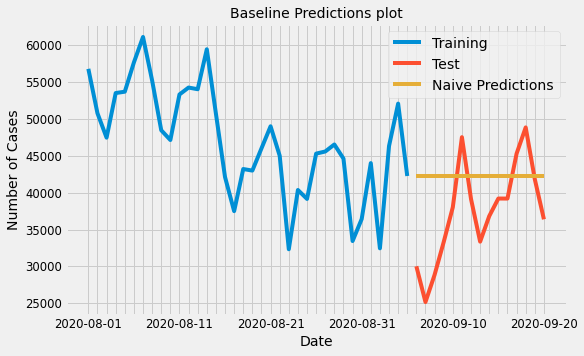

In [26]:
fig, ax = plt.subplots()
plt.plot(train.loc['2020-08-01':'2020-09-05'], label = 'Training')
plt.plot(test, label = 'Test')
plt.plot(naive_preds, label = 'Naive Predictions')
plt.legend(loc = 'upper right')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Baseline Predictions plot')
helper_plot(10)
plt.show()

## ARIMA model

In [28]:
arima = ARIMA(train, order=(2, 2, 2))
arima_fit = arima.fit(disp= 0)
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.case_day   No. Observations:                  228
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2192.868
Method:                       css-mle   S.D. of innovations           3587.211
Date:                Tue, 22 Sep 2020   AIC                           4397.735
Time:                        22:31:14   BIC                           4418.312
Sample:                    01-22-2020   HQIC                          4406.037
                         - 09-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              177.4239    304.749      0.582      0.560    -419.872     774.720
ar.L1.D.case_day     0.6716      0.046     14.546      0.000       0.581       0.762
ar.L2.D.case_day    -0.7568      0.046    -16.546      0.000      -0.846      -0.667
ma.L1.D.case_day    -0.6068      0.015    -39.267      0.000      -0.637      -0.576
ma.L2.D.case_day     1.0000      0.041     24.340      0.000       0.919       1.081
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.4437           -1.0604j            1.1495           -0.1869
AR.2            0.4437           +1.0604j            1.1495            0.1869
MA.1            0.3034           -0.9529j            1.0000           -0.2009
MA.2            0.3034           +0.9529j            1.0000            0.2009
-----------------------------------------------------------------------------
"""

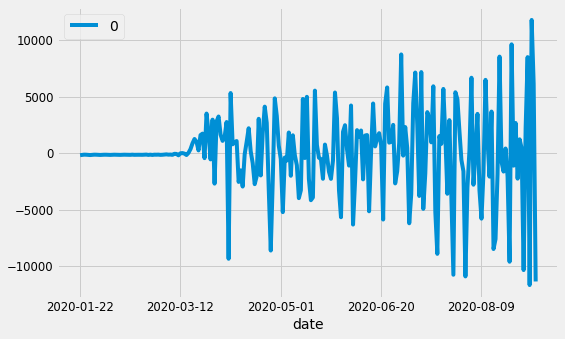

In [29]:
residuals = pd.DataFrame(arima_fit.resid)
residuals.plot()
plt.show()

In [30]:
preds = arima_fit.forecast(steps = 15)[0]

In [31]:
preds

array([44525.79788532, 42335.07790724, 39355.26811857, 39204.39731199,
       41550.60699587, 43433.03793313, 43114.30086446, 41668.21870946,
       41130.76357403, 42056.67683937, 43277.78194808, 43589.71974485,
       43067.66704422, 42673.52446692, 42996.41804471])

In [32]:
np.sqrt(mean_squared_error(preds, test))

7690.544809306026

In [33]:
df_us['case_day'].describe()

count      244.000000
mean     27974.430328
std      20905.013735
min          0.000000
25%       8037.750000
50%      26623.000000
75%      43426.250000
max      75682.000000
Name: case_day, dtype: float64

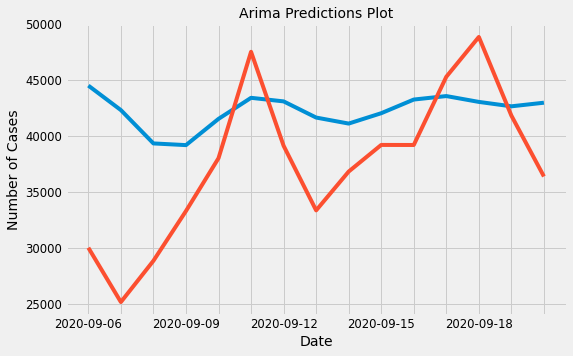

In [34]:
fig, ax = plt.subplots()
plt.plot(preds)
plt.plot(test)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Arima Predictions Plot')
helper_plot(3)

### Grid Search for ARIMA

In [ ]:
np.isfinite(train).all()

In [ ]:
len(train)

## ARIMA (7, 1 ,6)

In [36]:
best_arima = ARIMA(train, order=(7, 2, 6), exog=None)
best_arima_fit = best_arima.fit()


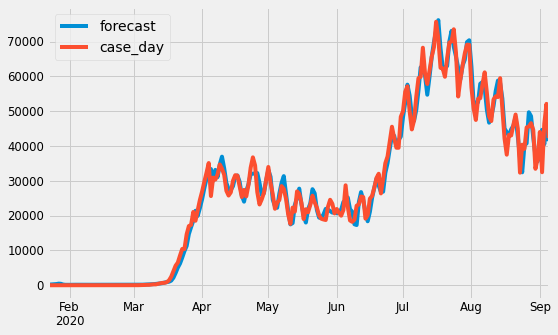

In [37]:
best_arima_fit.plot_predict()
plt.show()

In [39]:
preds = best_arima_fit.forecast(steps = 15)[0]

In [40]:
best_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.case_day   No. Observations:                  228
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -2119.095
Method:                       css-mle   S.D. of innovations           2602.411
Date:                Tue, 22 Sep 2020   AIC                           4260.191
Time:                        22:32:29   BIC                           4297.914
Sample:                    01-22-2020   HQIC                          4275.411
                         - 09-05-2020                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              194.7431    235.476      0.827      0.408    -266.782     656.268
ar.L1.D.case_day     0.4476      0.126      3.543      0.000       0.200       0.695
ar.L2.D.case_day    -0.3411      0.090     -3.770      0.000      -0.518      -0.164
ar.L3.D.case_day     0.1060      0.071      1.499      0.134      -0.033       0.244
ar.L4.D.case_day    -0.2072      0.073     -2.822      0.005      -0.351      -0.063
ar.L5.D.case_day    -0.0599      0.078     -0.764      0.445      -0.214       0.094
ar.L6.D.case_day     0.2484      0.082      3.045      0.002       0.089       0.408
ar.L7.D.case_day     0.3488      0.103      3.397      0.001       0.148       0.550
ma.L1.D.case_day    -0.8616      0.131     -6.559      0.000      -1.119      -0.604
ma.L2.D.case_day     0.5041      0.106      4.749      0.000       0.296       0.712
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1109           -0.0000j            1.1109           -0.0000
AR.2            0.6309           -0.7871j            1.0087           -0.1425
AR.3            0.6309           +0.7871j            1.0087            0.1425
AR.4           -0.2879           -1.0767j            1.1146           -0.2916
AR.5           -0.2879           +1.0767j            1.1146            0.2916
AR.6           -1.2546           -0.6838j            1.4288           -0.4206
AR.7           -1.2546           +0.6838j            1.4288            0.4206
MA.1            0.8546           -1.1195j            1.4085           -0.1462
MA.2            0.8546           +1.1195j            1.4085            0.1462
-----------------------------------------------------------------------------
"""

In [41]:
best_rmse = np.sqrt(mean_squared_error(preds, test))
print('Best ARIMA RMSE: ',best_rmse)

Best ARIMA RMSE:  8794.261545076688


In [42]:
preds

array([38518.47600968, 42067.07991907, 41736.67003954, 41175.50839629,
       49141.4682658 , 52008.85479014, 46100.0904712 , 43116.68558837,
       43728.71760089, 43157.4324298 , 45301.5945433 , 51073.09279027,
       52537.6667671 , 48820.20738046, 46058.72169594])

In [43]:
test

date
2020-09-06    30030
2020-09-07    25173
2020-09-08    28864
2020-09-09    33313
2020-09-10    38036
2020-09-11    47548
2020-09-12    39149
2020-09-13    33369
2020-09-14    36839
2020-09-15    39221
2020-09-16    39216
2020-09-17    45313
2020-09-18    48875
2020-09-19    41844
2020-09-20    36401
Name: case_day, dtype: int32

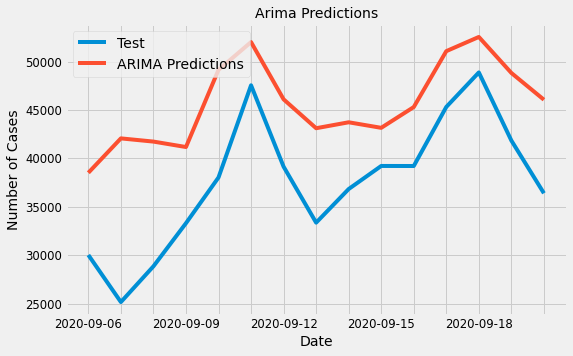

In [44]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(preds, label = 'ARIMA Predictions')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Arima Predictions')
helper_plot(3)
plt.show()

## AUTO ARIMA

In [ ]:
model_auto = auto_arima(train, start_p=1, start_q=1, d = 1,
                           max_p=20, max_q=20, trace=True,
                       error_action='ignore',  m = 1,
                           suppress_warnings=True, scoring = 'mse')

In [ ]:
model_auto_fit = model_auto.fit(train)

In [ ]:
preds = model_auto_fit.predict(n_periods = 15)

In [ ]:
preds

In [ ]:
test

In [ ]:
rmse = np.sqrt(mean_squared_error(preds, test))
print('Auto ARIMA RMSE: ',rmse)

## Simple Exponential Smoothing(SES)

In [ ]:
ses = SimpleExpSmoothing(train)
ses_fit = ses.fit()

In [ ]:
ses_preds = ses_fit.forecast(steps = 15)

In [ ]:
ses_preds

In [ ]:
np.sqrt(mean_squared_error(ses_preds, test))

## FBPROPHET

In [ ]:
X = pd.DataFrame(train)

In [ ]:
X.rename(columns = {'case_day':'y'}, inplace = True)
X.index.names = ['ds']
X.head()

In [ ]:
X['index'] = np.arange(len(X))

In [ ]:
X['ds'] = X.index

In [ ]:
X.set_index('index', inplace = True)


In [ ]:
model = Prophet()
model.fit(X)


In [ ]:
future = model.make_future_dataframe(periods = 15)
future.tail()

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


In [ ]:
fig1 = model.plot(forecast)


In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
#plot_plotly(model, forecast)

In [ ]:
#plot_components_plotly(model, forecast)

In [ ]:
np.sqrt(mean_squared_error(test, forecast['yhat'].tail(15)))


## TBATS

In [ ]:
tbats = TBATS()
tbats_fit = tbats.fit(train)

In [ ]:
preds_tbats = tbats_fit.forecast(steps = 15)

In [ ]:
np.sqrt(mean_squared_error(test, preds_tbats))

In [ ]:
test

In [ ]:
preds_tbats

## Helper functions for NN models

In [ ]:
# preparing data to features and target to feed to the model
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
def make_predictions(model, num_days, n_steps):
    x_input = Y[-n_steps:]
    x_input = x_input.reshape(1, n_steps, n_features)
    preds = []
    i = 0
    while i < num_days:
        pred = model.predict(x_input)[0][0]
        preds.append(pred)
        x_input = np.append(x_input[0], pred)
        x_input = x_input[-n_steps:]
        x_input = x_input.reshape(1, n_steps, n_features)
        i += 1
    
    return preds

## DNN

In [ ]:
n_steps = 20
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
dnn = Sequential()
dnn.add(Dense(32, input_shape=(n_steps, n_features), activation='relu'))
dnn.add(Dense(8, activation='relu'))
dnn.add(Dense(1))
dnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
dnn.fit(X,Y, epochs = 100, verbose=0 )

In [ ]:
dnn_preds =  make_predictions(dnn, 15, n_steps)

In [ ]:
dnn_preds

In [ ]:
np.sqrt(mean_squared_error(dnn_preds, test))

In [ ]:
plt.plot(test, label = 'Test')
plt.plot(dnn_preds, label = 'DNN Predictions')
plt.legend(loc = 'upper left')
plt.show()

## RNN

In [ ]:
n_steps = 15
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
rnn = Sequential()
rnn.add(SimpleRNN(32, input_shape=(n_steps, n_features), activation="relu"))
rnn.add(Dense(8, activation='relu'))
rnn.add(Dense(1))
rnn.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])

In [ ]:
rnn_fit = rnn.fit(X,Y, epochs = 100, verbose=0)

In [ ]:
rnn_preds =  make_predictions(rnn, 15, n_steps)

In [ ]:
rnn_preds

In [ ]:
np.sqrt(mean_squared_error(rnn_preds, test))

In [ ]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(rnn_preds, label = 'RNN Predictions')
plt.legend(loc = 'upper left')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
helper_plot(3)
plt.show()

## LSTM

### Building a model

In [ ]:
n_steps = 10
X, Y = prepare_data(train, n_steps)

# reshaping X from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
lstm = Sequential()
lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
lstm.add(LSTM(50, activation='relu'))
lstm.add(Dense(1))
lstm.compile(optimizer='adam', loss='mse' ,metrics = ['mse', 'mae'])
# fit model
lstm.fit(X, Y, epochs= 100, verbose=0)

In [ ]:
lstm_preds =  make_predictions(lstm, 15, n_steps)
lstm_preds

In [ ]:
np.sqrt(mean_squared_error(lstm_preds, test))

In [ ]:
l_preds = test.copy()
l_preds.replace(l_preds.values, lstm_preds, inplace = True)

In [ ]:
fig, ax = plt.subplots()
plt.plot(test, label = 'Test')
plt.plot(l_preds, label = 'LSTM Predictions')
plt.legend(loc = 'upper left')
helper_plot(3)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.show()